In [1]:
import os
import numpy as np
from random import shuffle
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam, SGD
from tqdm import tqdm

/root/miniconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

torch.cuda.set_device(2)
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print("device", torch.cuda.current_device(), torch.cuda.get_device_name(torch.cuda.current_device()))

device 2 NVIDIA GeForce RTX 2080 Ti


In [3]:
IMAGES_PATH = "wg4bpm33hj-2/images"
MASKS_PATH = "wg4bpm33hj-2/masks"
WEIGHT_PATH = "checkpoint"

EPOCHS = 200
BATCH_SIZE = 8
IMAGE_SIZE = 400
LR = 0.001
NUM_SAVE = 5
NK = 8

In [4]:
class CCAgTDataset(Dataset):
    def __init__(self, image_path: str, label_path: str, set_type="train", image_transform=None, label_transform=None) -> None:
        super().__init__()
        self.image_transform = image_transform
        self.label_transform = label_transform
        self.images = []
        self.labels = []
        self.data = []
        self.split_ratio = {"train": (0.0, 0.7), "val": (0.7, 0.8), "test": (0.8, 1.0)}
        self.maxV = 7
        self.mask_ratio = 255 // self.maxV
        
        assert set_type in self.split_ratio.keys(), "dataset type error"
  
        for root, dirs, files in os.walk(image_path):
            for f in files:
                self.images.append(os.path.join(root, f))
                
        for root, dirs, files in os.walk(label_path):
            for f in files:
                self.labels.append(os.path.join(root, f))
                
        assert len(self.images) == len(self.labels), f"data length error, {len(self.images)}, {len(self.labels)}"
        
        for ele in zip(sorted(self.images), sorted(self.labels)):
            self.data.append(ele)
        
        shuffle(self.data)
        self.data = self.data[int(len(self.data)*self.split_ratio[set_type][0]) : int(len(self.data)*self.split_ratio[set_type][1])]
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_path, mask_path = self.data[index]

        image = np.array(Image.open(image_path).convert("RGB"))
        #mask =  Image.open(mask_path).convert("L")
        mask =  np.array(Image.open(mask_path).convert("L"))
        mask[mask > 0] = 255
        #mask = mask * self.mask_ratio
        #print(np.max(mask))
        
        
        if self.image_transform is not None:
            image = self.image_transform(image)
            
        if self.label_transform is not None:
            mask = self.label_transform(mask)
        
        #mask = np.array(mask, dtype=np.float64) * self.mask_ratio
        #mask = torch.from_numpy(mask).unsqueeze(0)
            
        return image, mask

In [5]:
trainset = CCAgTDataset(IMAGES_PATH, MASKS_PATH, "train")
x, y = trainset[0]
print(np.max(y))
print(np.min(y))
print(y.shape)

255
0
(1200, 1600)


In [6]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.net(x)
    
    
class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up_layer = nn.ConvTranspose2d(in_channels, out_channels, 2, 2)
        self.double_conv = DoubleConv(in_channels, out_channels)
        
    def forward(self, x, keep):
        x = self.up_layer(x)
        x = torch.cat([x, keep], dim=1)
        x = self.double_conv(x)
        return x
        

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, hiddens=[64, 128, 256, 512]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList([Up(hidden*2, hidden) for hidden in hiddens[::-1]])
        self.pool = nn.MaxPool2d(2)
        
        for hidden in hiddens:
            self.downs.append(DoubleConv(in_channels, hidden))
            in_channels = hidden
            
        #for hidden in hiddens[::-1]:
        #    self.ups.append(Up(hidden*2, hidden))
            
        self.midden_layer = DoubleConv(hiddens[-1], hiddens[-1]*2)
        self.out_layer = nn.Conv2d(hiddens[0], out_channels, 1)
    
    def forward(self, x):
        keeps = []
        
        for down in self.downs:
            x = down(x)
            keeps.append(x)
            x = self.pool(x)
            
        x = self.midden_layer(x)
        keeps = keeps[::-1]
        
        for i, up in enumerate(self.ups):
            x = up(x, keeps[i])
            
        x = self.out_layer(x)
        return x
        

In [7]:
def test_network():
    ins = torch.randn(2, 3, 800, 800).to(device)
    net = UNet().to(device)
    out = net(ins)
    print(out.shape)
    
def save_weight(name: str):
        torch.save(net.state_dict(), os.path.join(WEIGHT_PATH, f"checkpoint_{name}.weight"))

def load_weight(name: str):
    net.load_state_dict(torch.load(os.path.join(WEIGHT_PATH, f"checkpoint_{name}.weight")))


In [8]:
image_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
label_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE))
    ])


trainset = CCAgTDataset(IMAGES_PATH, MASKS_PATH, "train", image_transform=image_transform, label_transform=label_transform)
trainLoader = DataLoader(trainset, batch_size=BATCH_SIZE, num_workers=NK, shuffle=True)

valset = CCAgTDataset(IMAGES_PATH, MASKS_PATH, "val", image_transform=image_transform, label_transform=label_transform)
valLoader = DataLoader(valset, batch_size=BATCH_SIZE, num_workers=NK, shuffle=True)

net = UNet().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(net.parameters(), lr=LR)
#optimizer = SGD(net.parameters(), lr=LR, momentum=0.9)
log = {"train_loss": [], "val_loss": []}

In [9]:
x, y = trainset[0]
print(y.dtype)

torch.float32


In [10]:
def train():
    try:
        for eps in range(EPOCHS):
            print(f"{eps} epoch:")
            total_train_loss = 0
            total_val_loss = 0
            # train
            print("train~")
            for ins, labels in tqdm(trainLoader):
                ins_gpu = ins.to(device)
                labels_gpu = labels.to(device)

                pred = net(ins_gpu)

                optimizer.zero_grad()
                loss = criterion(pred, labels_gpu)
                loss.backward()
                optimizer.step()

                total_train_loss += loss.item()

            # val
            print("val~")
            with torch.no_grad():
                net.eval()
                for ins, labels in tqdm(valLoader):
                    ins_gpu = ins.to(device)
                    labels_gpu = labels.to(device)

                    pred = net(ins_gpu)
                    total_val_loss += criterion(pred, labels_gpu).item()

            avg_train_loss = total_train_loss / len(trainLoader)
            avg_val_loss = total_val_loss / len(valLoader)

            if log["val_loss"] and avg_val_loss < np.min(log["val_loss"]):
                print("save best weight")
                save_weight("best")

            log["train_loss"].append(avg_train_loss)
            log["val_loss"].append(avg_val_loss)

            print(f"avg_train_loss: {avg_train_loss}, avg_val_loss: {avg_val_loss}")
            if eps and eps%NUM_SAVE == 0:
                save_weight(f"{eps}")
                train_loss = np.array(log["train_loss"])
                val_loss = np.array(log["val_loss"])
                np.save("checkpoint/train_loss", train_loss)
                np.save("checkpoint/val_loss", val_loss)
                
    except KeyboardInterrupt:
        print("interrupt")
        save_weight("interrupt")
        train_loss = np.array(log["train_loss"])
        val_loss = np.array(log["val_loss"])
        np.save("checkpoint/train_loss", train_loss)
        np.save("checkpoint/val_loss", val_loss)
        
    print("END")
    save_weight("END")
    train_loss = np.array(log["train_loss"])
    val_loss = np.array(log["val_loss"])
    np.save("checkpoint/train_loss", train_loss)
    np.save("checkpoint/val_loss", val_loss)
        

In [11]:
train()

0 epoch:
train~


100%|██████████| 818/818 [09:18<00:00,  1.46it/s]


val~


100%|██████████| 117/117 [00:29<00:00,  3.94it/s]


avg_train_loss: 0.0497141626315114, avg_val_loss: 0.02029441194768008
1 epoch:
train~


100%|██████████| 818/818 [09:01<00:00,  1.51it/s]


val~


100%|██████████| 117/117 [00:29<00:00,  4.00it/s]


avg_train_loss: 0.019636206983527155, avg_val_loss: 0.020734411067305468
2 epoch:
train~


100%|██████████| 818/818 [09:00<00:00,  1.51it/s]


val~


100%|██████████| 117/117 [00:29<00:00,  3.99it/s]


save best weight
avg_train_loss: 0.016389881688213398, avg_val_loss: 0.015775642306026485
3 epoch:
train~


100%|██████████| 818/818 [08:56<00:00,  1.53it/s]


val~


100%|██████████| 117/117 [00:29<00:00,  3.96it/s]


save best weight
avg_train_loss: 0.014685253792585838, avg_val_loss: 0.014496068734850766
4 epoch:
train~


100%|██████████| 818/818 [08:56<00:00,  1.52it/s]


val~


100%|██████████| 117/117 [00:29<00:00,  4.02it/s]


save best weight
avg_train_loss: 0.013668379431287587, avg_val_loss: 0.01318522792460763
5 epoch:
train~


100%|██████████| 818/818 [08:55<00:00,  1.53it/s]


val~


100%|██████████| 117/117 [00:29<00:00,  3.99it/s]


save best weight
avg_train_loss: 0.012662795050101568, avg_val_loss: 0.012404293430825839
6 epoch:
train~


100%|██████████| 818/818 [08:55<00:00,  1.53it/s]


val~


100%|██████████| 117/117 [00:29<00:00,  4.00it/s]


save best weight
avg_train_loss: 0.010915586226483157, avg_val_loss: 0.009929766767045371
7 epoch:
train~


100%|██████████| 818/818 [08:58<00:00,  1.52it/s]


val~


100%|██████████| 117/117 [00:29<00:00,  3.99it/s]


save best weight
avg_train_loss: 0.009610771845962424, avg_val_loss: 0.008842814737596573
8 epoch:
train~


100%|██████████| 818/818 [08:54<00:00,  1.53it/s]


val~


100%|██████████| 117/117 [00:29<00:00,  3.99it/s]


save best weight
avg_train_loss: 0.008742708467746331, avg_val_loss: 0.008455363784829138
9 epoch:
train~


100%|██████████| 818/818 [08:54<00:00,  1.53it/s]


val~


100%|██████████| 117/117 [00:29<00:00,  3.98it/s]


save best weight
avg_train_loss: 0.008333247543761193, avg_val_loss: 0.008417230079539565
10 epoch:
train~


100%|██████████| 818/818 [08:55<00:00,  1.53it/s]


val~


100%|██████████| 117/117 [00:29<00:00,  3.98it/s]


save best weight
avg_train_loss: 0.0079426394855492, avg_val_loss: 0.007633109204869112
11 epoch:
train~


 11%|█         | 88/818 [00:59<08:12,  1.48it/s]


interrupt
END


In [12]:
def show_image(ins, gts, preds):
    fig, axs = plt.subplots(3, 2, figsize=(10, 6), constrained_layout=True)
    print(ins[0].shape)
    print(gts[0].shape)
    print(preds[0].shape)
    print(torch.max(gts[0]))
    print(torch.min(gts[0]))
    print(torch.max(preds[0]))
    print(torch.min(preds[0]))
    preds = (preds+1)*255 / 2
    axs[0, 0].imshow(ins[0].permute(1, 2, 0))
    axs[0, 1].imshow(ins[1].permute(1, 2, 0))
    axs[1, 0].imshow(gts[0].permute(1, 2, 0))
    axs[1, 1].imshow(gts[1].permute(1, 2, 0))
    axs[2, 0].imshow(preds[0].permute(1, 2, 0))
    axs[2, 1].imshow(preds[1].permute(1, 2, 0))
        


def test():
    image_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    label_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE))
    ])
    
    
    testset = CCAgTDataset(IMAGES_PATH, MASKS_PATH, "test", image_transform=image_transform, label_transform=label_transform)
    testLoader = DataLoader(testset, batch_size=BATCH_SIZE, num_workers=NK, shuffle=True)
    net = UNet().to(device)
    load_weight("best")
    
    with torch.no_grad():
        net.eval()
        for ins, labels in tqdm(testLoader):
            ins_gpu = ins.to(device)
            labels_gpu = labels.to(device)

            pred = net(ins_gpu)
            test_loss = criterion(pred, labels_gpu).item()
            print(test_loss)
            show_image(ins, labels, pred.cpu())
            break
            

  0%|          | 0/234 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.6520849466323853
torch.Size([3, 400, 400])
torch.Size([1, 400, 400])
torch.Size([1, 400, 400])
tensor(1.)
tensor(0.)
tensor(-0.0752)
tensor(-0.0908)


  0%|          | 0/234 [00:02<?, ?it/s]


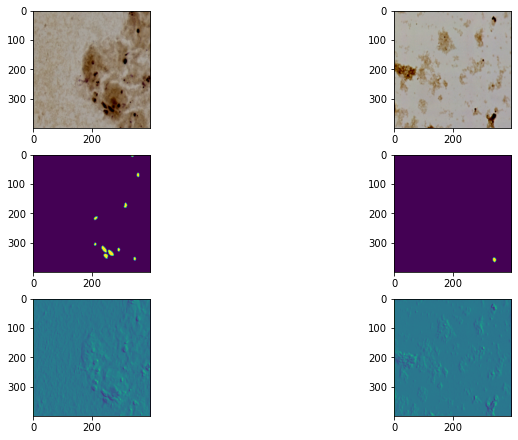

In [13]:
test()

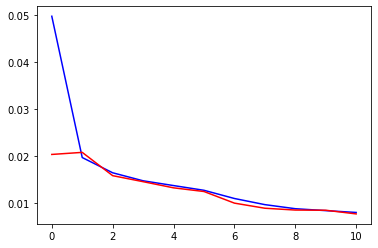

In [14]:
train_loss = np.load("checkpoint/train_loss.npy")
val_loss = np.load("checkpoint/val_loss.npy")

plt.plot(train_loss, color="blue")
plt.plot(val_loss, color="red")
plt.show()

In [15]:
def pixel_accuracy(predictions, labels):
    correct = (predictions == labels).float()
    pacc = correct.sum() / correct.numel()
    return pacc

def class_pixel_accuracy(predictions, labels, num_classes):
    correct = (predictions == labels).float()
    class_correct = [correct[labels == i].sum() for i in range(num_classes)]
    class_total = [labels[labels == i].numel() for i in range(num_classes)]
    class_acc = [c / t for c, t in zip(class_correct, class_total)]
    return sum(class_acc) / num_classes

